In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Month                                                   106 non-null    object 
 1   Perrin Freres monthly champagne sales millions ?64-?72  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [5]:
# Dropping the missing data
df.dropna(inplace = True)

In [6]:
df.columns = ['Month', 'Sales']
df

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0
...,...,...
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0


In [7]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [8]:
# We need to convert the month column into datetime format and hence change the datatype of that column
import datetime

df['Month'] = pd.to_datetime(df['Month'])

In [9]:
df.set_index('Month', inplace = True)

In [10]:
# Since its a time series data replacing the index with Datetime 
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


<AxesSubplot:xlabel='Month'>

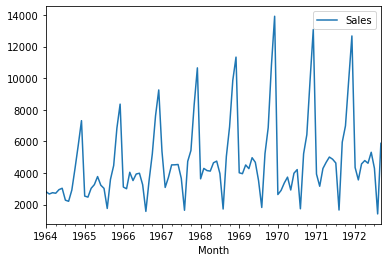

In [11]:
# Visualize the data 
df.plot()

In [12]:
# As we can check that there is both stationarity and seasonality in the data, hence we first treat the stationarity

## AD Fuller test (Augmented Dicky Fuller test)

In [13]:
# AD Fuller test used to check both the stationarity and seasonality in the data
# Checking for stationaity first

from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary(NUll Hypothesis)
#H1: It is stationary(Alternate Hypothesis)

def adfuller_test(sales):
    result = adfuller(sales)
    print('p-value: {}'.format(result[1]))
    if result[1] < 0.05:
        print("Strong evidence against Null hypothesis, thus rejecting the same indicating the data is stationary")
    else:
        print("Weak evidence against Null hypothesis, indicating the data is not stationary")

In [14]:
# In ADfuller test the index 1 gives the p- value that helps us determine whether the data is stationary or not
adfuller(df['Sales'])

(-1.8335930563276195,
 0.3639157716602467,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [15]:
# Since the p-value is above the threshold value hence we can conclude that the data is not stationary
adfuller_test(df['Sales'])

p-value: 0.3639157716602467
Weak evidence against Null hypothesis, indicating the data is not stationary


## Using the differencing method we will make the data Stationary

In [16]:
df['Sales First Diff'] = df['Sales'] - df['Sales'].shift(1)

In [17]:
df['Sales First Diff']

Month
1964-01-01       NaN
1964-02-01    -143.0
1964-03-01      83.0
1964-04-01     -34.0
1964-05-01     225.0
               ...  
1972-05-01    -170.0
1972-06-01     694.0
1972-07-01   -1014.0
1972-08-01   -2885.0
1972-09-01    4464.0
Name: Sales First Diff, Length: 105, dtype: float64

<AxesSubplot:xlabel='Month'>

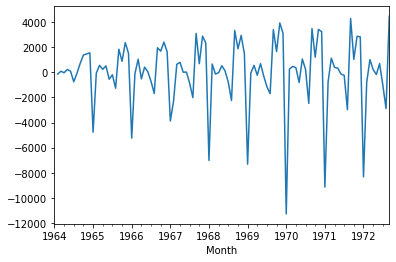

In [18]:
df['Sales First Diff'].plot()

In [19]:
# Now we can see that the data is stationary however there is seasonality in it. 
# Applying the ADFuller test again 
adfuller_test(df['Sales First Diff'].dropna())

p-value: 2.51962044738698e-10
Strong evidence against Null hypothesis, thus rejecting the same indicating the data is stationary


## Auto Regressive Model

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

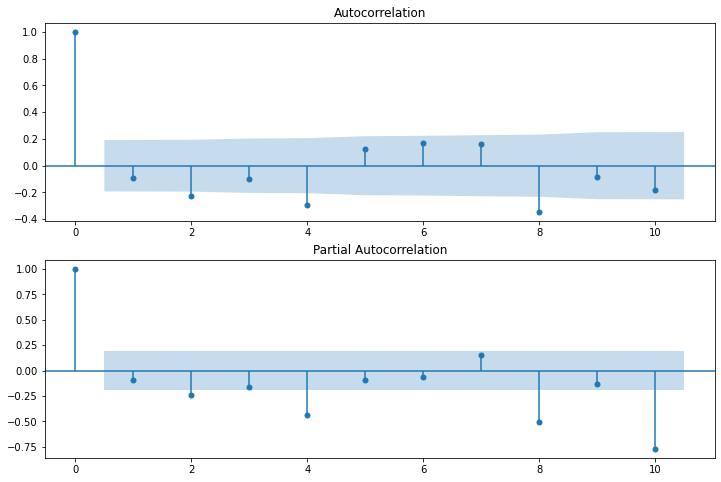

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Sales First Diff'].iloc[1:],lags=10,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Sales First Diff'].iloc[1:],lags=10,ax=ax2)

In [22]:
# For non-seasonal data
#p=1, d=1, q=1
from statsmodels.tsa.arima_model import ARIMA

In [23]:
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()

C:\Users\sayan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sayan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Month'>

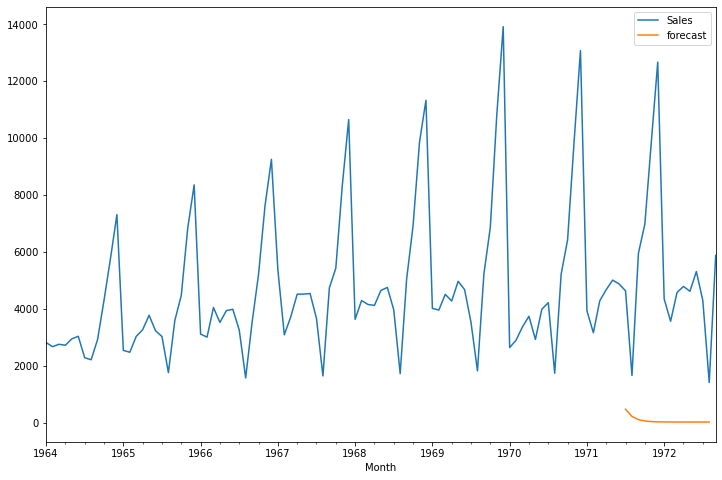

In [24]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [25]:
# As we can check the forecast is not according to what we wanted as there is seasonality in the data

<AxesSubplot:xlabel='Month'>

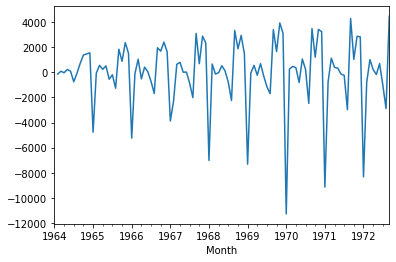

In [27]:
df['Sales First Diff'].plot()

In [28]:
# As we can the check the trend is after every 12 months os we shift the data by 12 and substarct it to remove the seasonality
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

<AxesSubplot:xlabel='Month'>

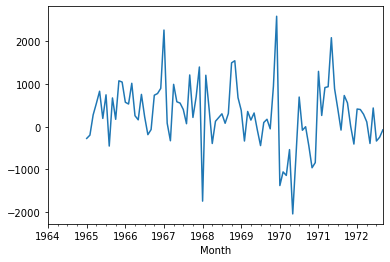

In [29]:
# Now we can check that the data is both stationary and there is no seasonality as well
df['Seasonal First Difference'].plot()

In [30]:
# Model for Seasonal ARIMA
import statsmodels.api as sm

In [31]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\sayan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sayan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<AxesSubplot:xlabel='Month'>

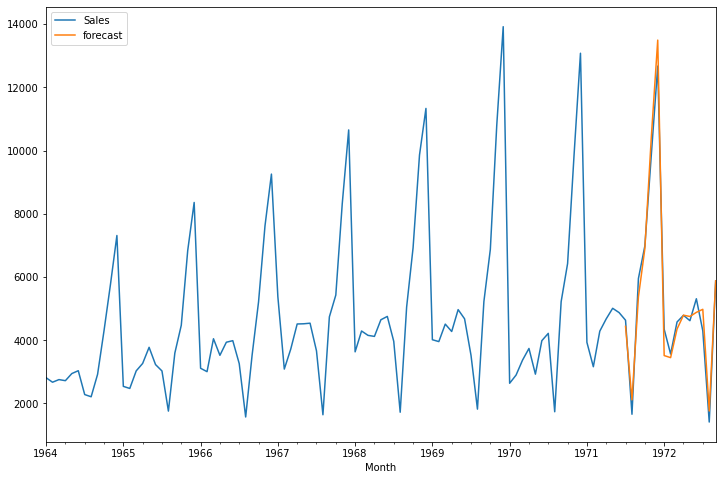

In [32]:
df['forecast']=results.predict(start=90,end=104)
df[['Sales','forecast']].plot(figsize=(12,8))